In [1]:
from importlib import reload

In [2]:
import torch
from torchvision import models
from itertools import chain
from collections import OrderedDict
import copy
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage import transform
import pandas as pd
import json
from train_mnist_model import Net as ConvNet
from train_mnist_model import preprocessing

import imp
LRP = imp.load_source('LRP', '../__init__.py')
from LRP.lrp import LRP
from LRP.utils import flatten_model
from skimage import io
from skimage import transform 

In [3]:
def norm_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

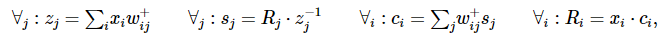

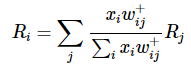

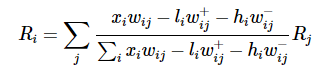

# MNIST test

## Conv net

In [30]:
model = ConvNet()
model.load_state_dict(torch.load('mnist_model.ph'))
model = model.eval()
# model = utils.redefine_nn(model, rule='z_plus_no_bias')
lrp = LRP(model, rule='z_plus')

In [31]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(preprocessing),

#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

In [32]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Lambda(preprocessing),

#                                torchvision.transforms.Normalize(
#                                  (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

#### add hook to modules

In [33]:
# outputs_back = []
# forward_back = []
# for module in flatten_model(lrp.model):
#     module.register_backward_hook(lambda *x: outputs_back.append([*x]))
# for module in flatten_model(lrp.model):
#     module.register_forward_hook(lambda *x: forward_back.append(x))

Label  7
Prediction 7
relevance mean tensor(0.0004)


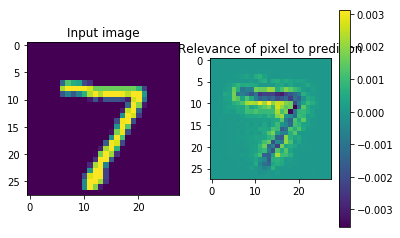

Label  2
Prediction 2
relevance mean tensor(0.0004)


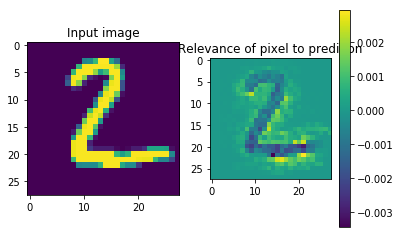

Label  1
Prediction 1
relevance mean tensor(0.0003)


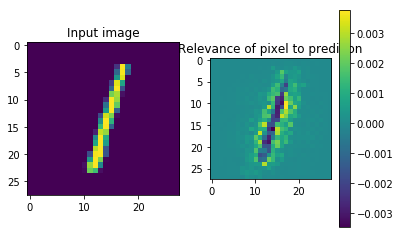

Label  0
Prediction 0
relevance mean tensor(0.0004)


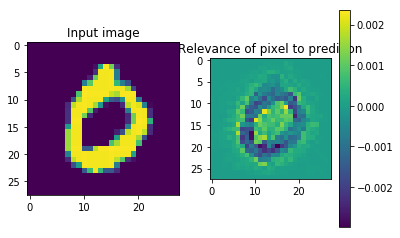

Label  4
Prediction 4
relevance mean tensor(0.0004)


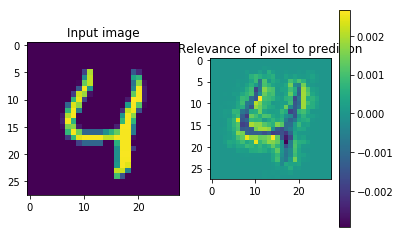

Label  1
Prediction 1
relevance mean tensor(0.0003)


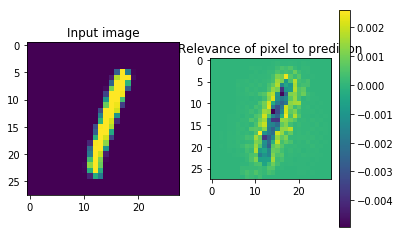

Label  4
Prediction 4
relevance mean tensor(0.0004)


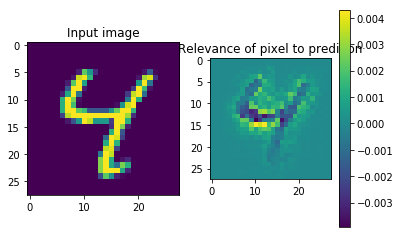

Label  9
Prediction 9
relevance mean tensor(0.0003)


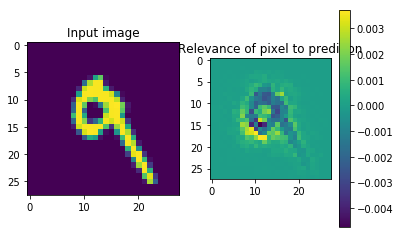

Label  5
Prediction 5
relevance mean tensor(0.0004)


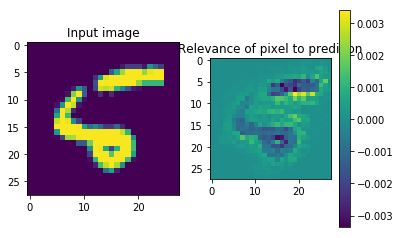

Label  9
Prediction 9
relevance mean tensor(0.0003)


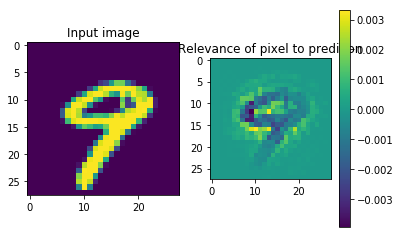

Label  0
Prediction 0
relevance mean tensor(0.0003)


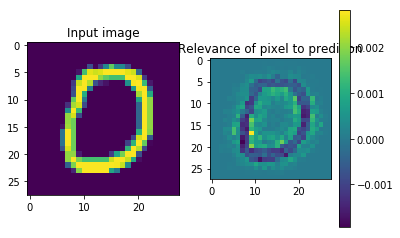

In [34]:
cmap = plt.cm.get_cmap('seismic')
for num, (image, label) in enumerate(test_loader):
    if num > 10:
        break
    print('Label ', label.item())
    output = lrp.forward(image)
    print('Prediction', output.argmax().item())
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image.squeeze().detach())
    ax[0].title.set_text('Input image')
    relevance = lrp.relprop()
    print('relevance mean', relevance.abs().mean())
#     img = ax[1].imshow(norm_tensor(relevance.squeeze()))
    img = ax[1].imshow(relevance.squeeze())
    fig.colorbar(img)
    ax[1].title.set_text('Relevance of pixel to predition')
    plt.show()
  

#### Mistakes

Label  9
Prediction 8


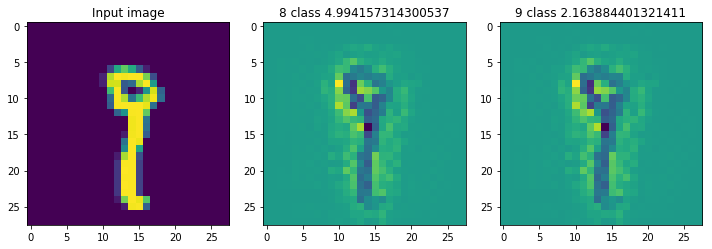

Label  2
Prediction 7


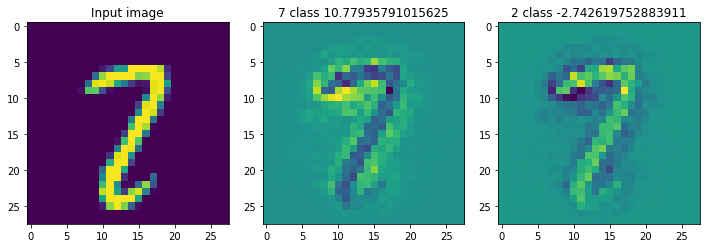

Label  6
Prediction 0


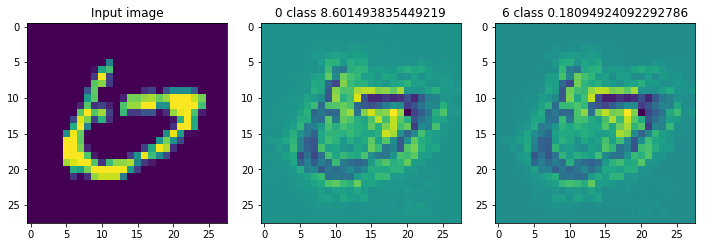

Label  6
Prediction 4


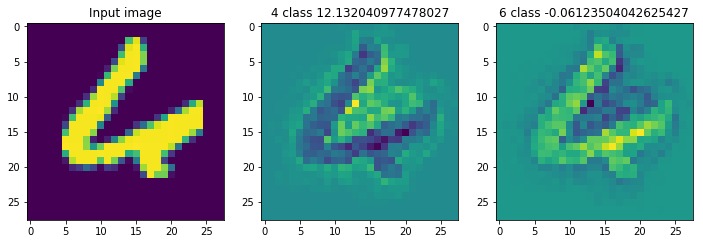

In [35]:
count = 0
for num, (image, label) in enumerate(test_loader):
    if count > 3:
        break
    output = lrp.forward(image)
    if output.argmax() != label:
        count += 1
        print('Label ', label.item())
        print('Prediction', output.argmax().item())
        _, ax = plt.subplots(1,3, figsize=(10,10))
        ax[0].imshow(image.squeeze())
        ax[0].title.set_text('Input image')
       
        R1 = torch.zeros_like(output)
        R1[0, output.argmax().item()] = 1
        
        relevance1 = lrp.relprop(R1*output)
        #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
        ax[1].imshow(norm_tensor(relevance1.squeeze()))
        ax[1].title.set_text('{} class {}'.format(output.argmax().item(), output.max().item()))
        
        R2 = torch.zeros_like(output)
        R2[0, label.item()] = 1
        
        relevance2 = lrp.relprop(R2*output)
        #ax[2].imshow(cmap(norm_tensor(relevance2.squeeze())))
        ax[2].imshow(norm_tensor(relevance2.squeeze()))
        ax[2].title.set_text('{} class {}'.format(label.item(), output.squeeze()[label].item()))
        plt.tight_layout()
        plt.show()

# Neuron selection. Iteration over outputs

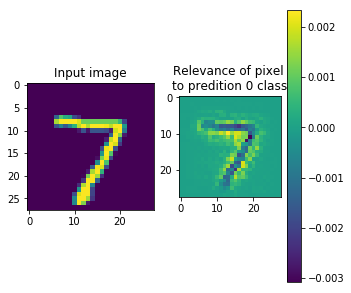

Logit value -128.32501220703125


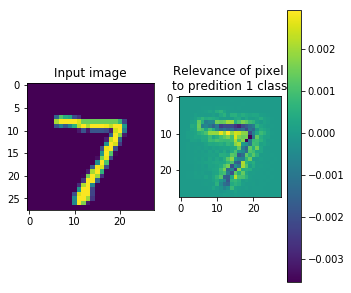

Logit value -33.40874481201172


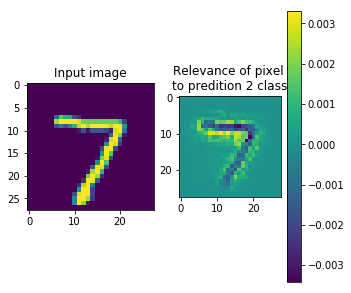

Logit value -39.145877838134766


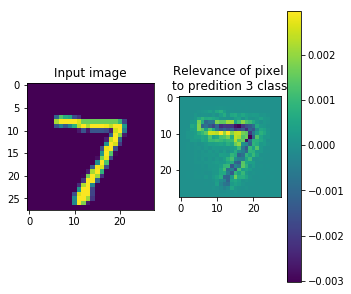

Logit value -85.9833755493164


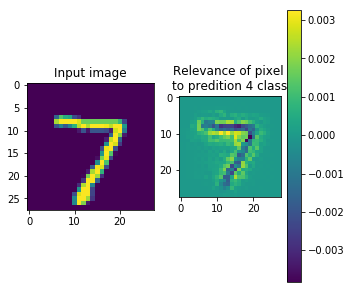

Logit value -33.19857406616211


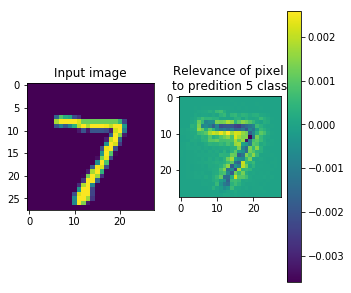

Logit value -75.41692352294922


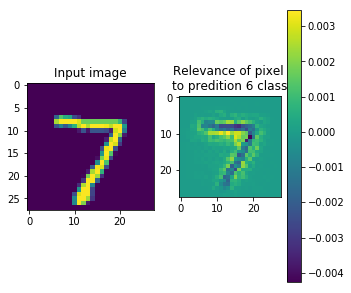

Logit value -143.80934143066406


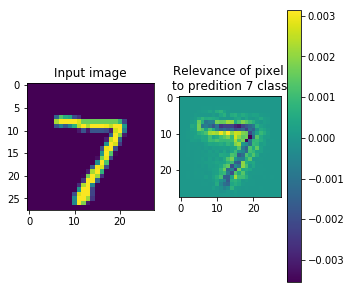

Logit value 32.32551956176758


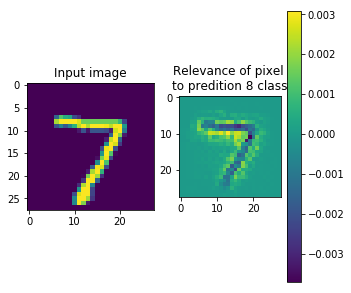

Logit value -64.59585571289062


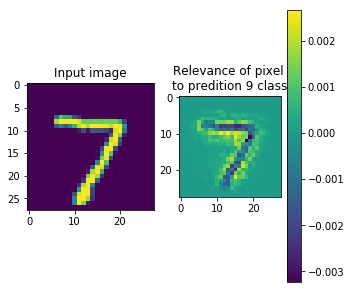

Logit value -46.97087860107422


In [36]:
image, label = next(iter(test_loader))
output = lrp.forward(image)
for selected_neuron in range(10):
    fig, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(image.squeeze())
    ax[0].title.set_text('Input image')

    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp.relprop(R1)
    #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
#     img = ax[1].imshow(norm_tensor(relevance1.squeeze()))
    img = ax[1].imshow(relevance1.squeeze())
    ax[1].title.set_text('Relevance of pixel \nto predition {} class'.format(selected_neuron))
    fig.colorbar(img)
    plt.show()
    print('Logit value {}'.format(output.squeeze().detach().numpy()[selected_neuron]))
    print('='*50)

# Uniform input. Interpretation of prediction

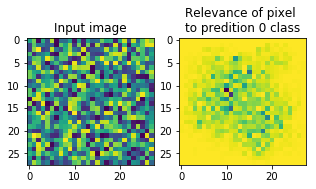

Logit value -6.506498336791992


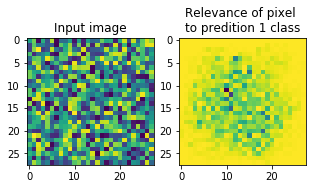

Logit value -2.5706613063812256


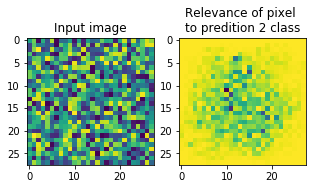

Logit value -5.057199478149414


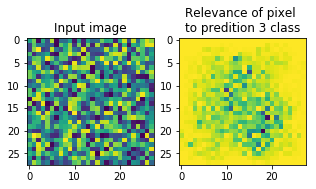

Logit value -5.192066192626953


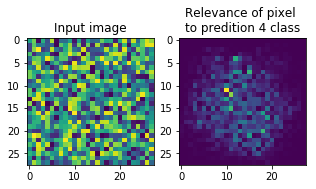

Logit value -3.619018077850342


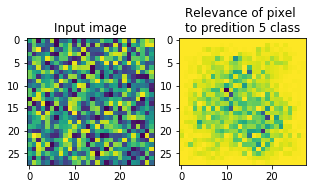

Logit value -0.6695607900619507


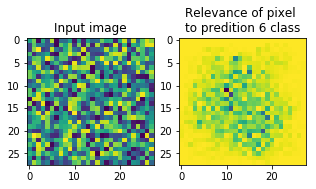

Logit value -1.6402913331985474


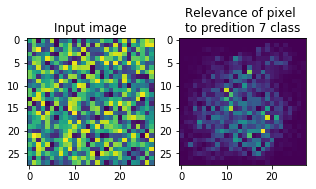

Logit value -6.11605978012085


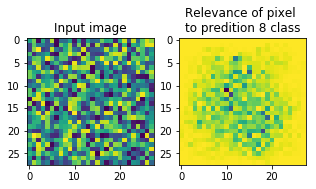

Logit value 2.069430112838745


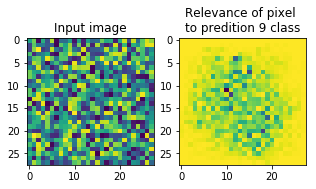

Logit value -2.0458457469940186


In [37]:
image = torch.rand((1, 1, 28, 28))

output = lrp.forward(image)
for selected_neuron in range(10):
    fig, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(image.squeeze())
    ax[0].title.set_text('Input image')

    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp.relprop(R1)
    #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
    ax[1].imshow(norm_tensor(relevance1.squeeze()))
    ax[1].title.set_text('Relevance of pixel \nto predition {} class'.format(selected_neuron))
    plt.show()
    
    print('Logit value {}'.format(output.squeeze().detach().numpy()[selected_neuron]))
    print('='*50)

## So if we include obtained relevance in input image, does it make it more class like for nn?

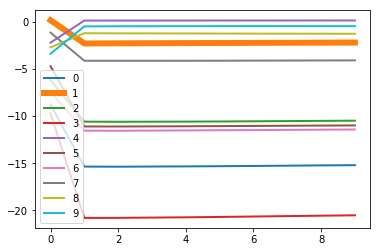

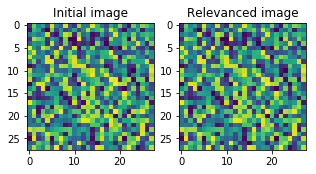

In [38]:
image = torch.rand((1, 1, 28, 28))
initial_image = image
selected_neuron = 1 # choose number
out_log = []
for i in range(10): # tune iterations number
    output = lrp.forward(image)
#     _, ax = plt.subplots(1,2, figsize=(5,5))
#     ax[0].imshow(image.squeeze())
#     ax[0].title.set_text('Input image')
    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp.relprop(R1*output)
#     ax[1].imshow(norm_tensor(relevance1.squeeze()))
#     ax[1].title.set_text('Relevance image')
#     plt.show()

    image = image - image*relevance1*(relevance1>0).float() + image*relevance1*(relevance1<0).float() #*(torch.sign(output[:,selected_neuron].detach()))
    image = image - image.min()
    image = 2*image/image.max() - 1
    out_log.append(output.squeeze().detach().numpy())


for i in range(10):
    _ = plt.plot(np.array(out_log)[:, i], label=i, linewidth=6.0 if i==selected_neuron else 2.0)
plt.legend()
plt.show()
_, ax = plt.subplots(1,2, figsize=(5,5))
ax[0].imshow(norm_tensor(initial_image.squeeze()))
ax[0].title.set_text('Initial image')
ax[1].imshow(norm_tensor(image.squeeze()))
ax[1].title.set_text('Relevanced image')
plt.show()

Obviouslly it's not so clear for convnet. Moreover why we subtrace relevance rather add?

# Occluded respectively to relevance

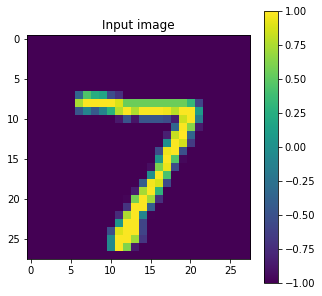

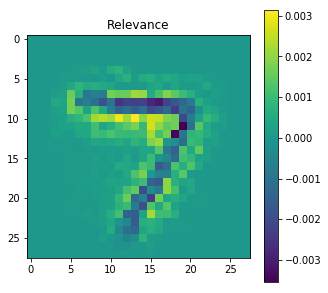

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].


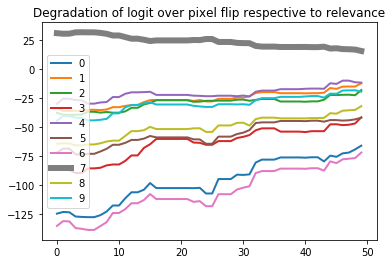

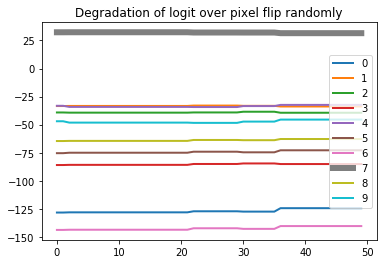

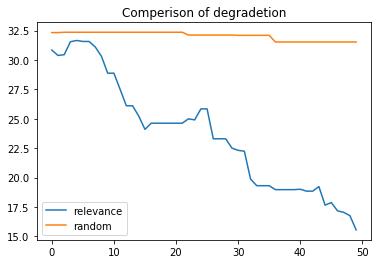

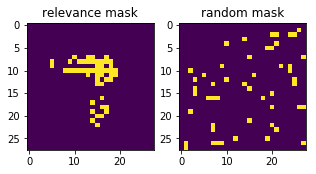

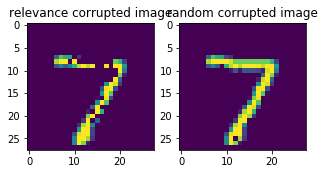

In [41]:
image, label = next(iter(test_loader))
image_copy = copy.deepcopy(image)
image_copy_2 = copy.deepcopy(image)
selected_neuron = 7
number_of_corrupted_pixels = 50

fig, ax = plt.subplots(1,1, figsize=(5,5))
img = ax.imshow(image.squeeze())
ax.title.set_text('Input image')
fig.colorbar(img)
plt.show()


output = lrp.forward(image)
R1 = torch.zeros_like(output)
R1[0, selected_neuron] = 1
relevance = lrp.relprop(R1)

fig, ax = plt.subplots(1,1, figsize=(5,5))
img = ax.imshow(relevance.squeeze())
ax.title.set_text('Relevance')
fig.colorbar(img)
plt.show()

image_pixel_indx = torch.stack(torch.meshgrid([torch.range(0, x-1) for x in image.shape if x!=1]), 2).view(-1, 2).long()
flatten_image, sort_indx = torch.sort(relevance.abs().squeeze().flatten(), descending=True)
output_list = []
blank_image = torch.zeros((28,28))
for num, si in enumerate(sort_indx[:number_of_corrupted_pixels]):
#     if flatten_image[num] < 0:
#         print('Last positive relevance value was under nuver', num)
#         break
    image_copy[:,:,image_pixel_indx[si][0], image_pixel_indx[si][1]] = -1
    blank_image[image_pixel_indx[si][0], image_pixel_indx[si][1]] = 1
    output = lrp.forward(image_copy)
    output_list.append(output.squeeze().detach().numpy())

for i in range(10):
    _ = plt.plot(np.array(output_list)[:, i], label=i, linewidth=6.0 if i==selected_neuron else 2.0)
plt.legend()
plt.title('Degradation of logit over pixel flip respective to relevance')
plt.show()

flatten_random_image, sort_random_indx = torch.sort(torch.rand((28, 28)).flatten()*2-1, descending=True)
output_list_random = []
blank_image_random = torch.zeros((28,28))

for si in sort_random_indx[:number_of_corrupted_pixels]:
    image_copy_2[:,:,image_pixel_indx[si][0], image_pixel_indx[si][1]] = -1
    blank_image_random[image_pixel_indx[si][0], image_pixel_indx[si][1]] = 1
    output = lrp.forward(image_copy_2)
    output_list_random.append(output.squeeze().detach().numpy())
    
for i in range(10):
    _ = plt.plot(np.array(output_list_random)[:, i], label=i, linewidth=6.0 if i==selected_neuron else 2.0)
plt.legend()
plt.title('Degradation of logit over pixel flip randomly')
plt.show()

_ = plt.plot(np.array(output_list)[:, selected_neuron], label='relevance')
_ = plt.plot(np.array(output_list_random)[:, selected_neuron], label='random')
plt.legend()
plt.title('Comperison of degradetion')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(blank_image)
ax[0].title.set_text('relevance mask')
ax[1].imshow(blank_image_random)
ax[1].title.set_text('random mask')
plt.show()

fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].imshow(image_copy.squeeze())
ax[0].title.set_text('relevance corrupted image')
ax[1].imshow(image_copy_2.squeeze())
ax[1].title.set_text('random corrupted image')

# Overfit fully connected nn

In [42]:
from train_mnist_model_overfit import Fcnn
model_over = Fcnn()
model_over.load_state_dict(torch.load('mnist_model_overfit_class5.ph'))
model_over = model_over.eval()
lrp_over = LRP(model_over, 'z_plus')

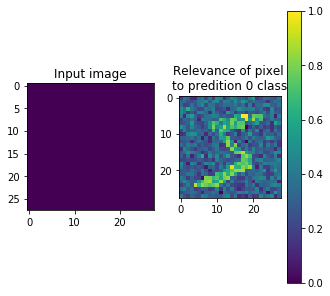

Logit value -2.5343310832977295


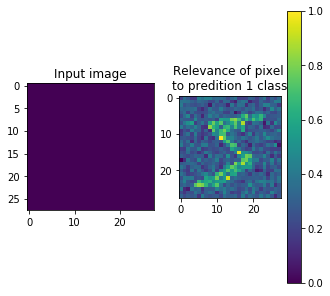

Logit value -2.29670786857605


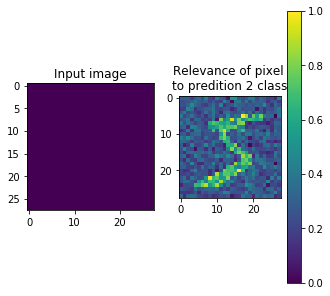

Logit value -1.513064980506897


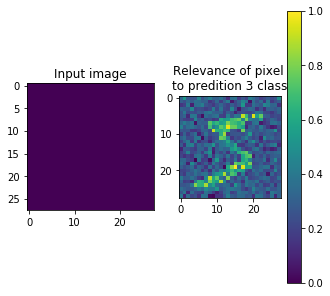

Logit value -2.362119197845459


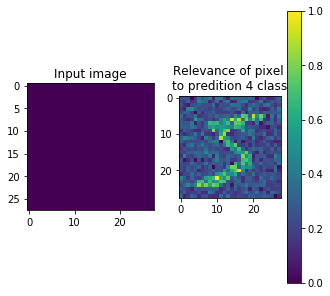

Logit value -1.2920669317245483


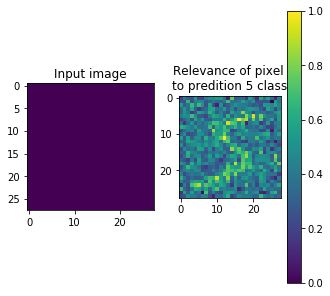

Logit value -3.8384816646575928


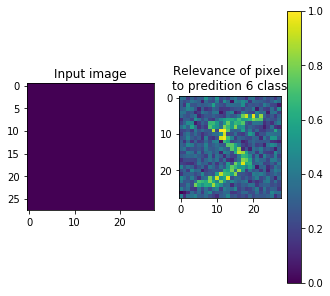

Logit value -1.5328822135925293


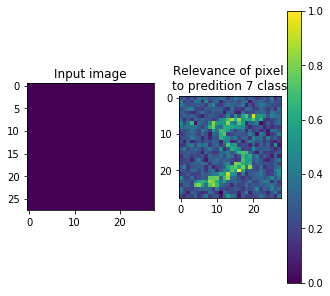

Logit value -1.8090629577636719


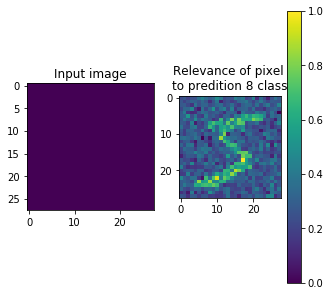

Logit value -1.2620749473571777


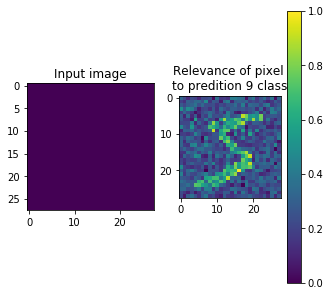

Logit value -1.9845914840698242


In [43]:
image = torch.ones_like(image) - 0.5
# image = next(iter(train_loader))[0]
output = lrp_over.forward(image)

for selected_neuron in range(10):
    fig, ax = plt.subplots(1,2, figsize=(5,5))
    ax[0].imshow(image.squeeze())
    ax[0].title.set_text('Input image')

    R1 = torch.zeros_like(output)
    R1[0, selected_neuron] = 1

    relevance1 = lrp_over.relprop(R1*output)
    relevance1 = relevance1.view(28,28)
    #ax[1].imshow(cmap(norm_tensor(relevance1.squeeze())))
    img = ax[1].imshow(norm_tensor(relevance1.squeeze()))
    ax[1].title.set_text('Relevance of pixel \nto predition {} class'.format(selected_neuron))
    fig.colorbar(img)
    plt.show()
    print('Logit value {}'.format(output.squeeze().detach().numpy()[selected_neuron]))
    print('='*50)